In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models

import matplotlib.pyplot as plt
import numpy as np

import shutil
import os
import pandas as pd

device = ("cuda" if torch.cuda.is_available() else "cpu")

## Split Data

In [2]:
df = pd.read_csv('./image_attributes_filtered.csv')

In [3]:
df = df[['Male','image_id']]

In [4]:
df

,Male,image_id
0,1,000051.jpg
1,1,000052.jpg
2,1,000065.jpg
3,1,000166.jpg
4,-1,000198.jpg
...,...,...
4995,-1,202320.jpg
4996,-1,202340.jpg
4997,-1,202347.jpg
4998,-1,202357.jpg


In [5]:
# Path to the images folder
images_folder = './Dataset/images'

# Create directories to store the filtered images
base_folder = './Dataset/data_vgg/'
male_folder = './Dataset/data_vgg/male/'
female_folder = './/Dataset/data_vgg/female/'
os.makedirs(base_folder, exist_ok=True)
os.makedirs(male_folder, exist_ok=True)
os.makedirs(female_folder, exist_ok=True)

for _, row in df.iterrows():
    image_id = row['image_id']
    male = row['Male']
    image_path = os.path.join(images_folder, image_id)
    
    if male == 1:
        shutil.copyfile(image_path, os.path.join(male_folder, image_id))
    elif male == -1:
        shutil.copyfile(image_path, os.path.join(female_folder, image_id))

## Extract Data

In [2]:
img_list = os.listdir('./Dataset/data_vgg/male/')
img_list.extend(os.listdir('./Dataset/data_vgg/female/'))
print("Images: ", len(img_list))

Images:  5000


In [3]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

batch_size = 8
celeba_data = datasets.ImageFolder('./Dataset/data_vgg', transform=transform)

In [5]:
print(celeba_data.classes)
print(len(celeba_data))

['female', 'male']
5000


In [6]:
class_names = celeba_data.classes

In [7]:
train_set, test_set = torch.utils.data.random_split(celeba_data, [int(len(img_list) * 0.75), len(img_list) - int(len(img_list) * 0.75)])
train_data_size = len(train_set)
test_data_size = len(test_set)

In [8]:
trainLoader = torch.utils.data.DataLoader(train_set,batch_size=batch_size, shuffle=True)
testLoader  = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

In [9]:
print(train_data_size)
print(test_data_size)

3750
1250


## Train

In [2]:
batch_size = 4
learning_rate = 0.0001
epochs = 50


model = models.vgg16()
model.classifier[6] = nn.Linear(4096, 2)
model = model.to('cuda')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [11]:
# Train the model
for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(trainLoader, 0):
        # Get the inputs
        inputs, labels = data
        inputs, labels = inputs.to('cuda'), labels.to('cuda')

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if i % 100 == 99:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0

    # Test the model
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testLoader:
            images, labels = data
            images, labels = images.to('cuda'), labels.to('cuda')
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the test images: %d %%' % (
        100 * correct / total))

print('Finished Training')

[1,   100] loss: 0.785
[1,   200] loss: 0.707
[1,   300] loss: 0.683
[1,   400] loss: 0.688
Accuracy of the network on the test images: 59 %
[2,   100] loss: 0.697
[2,   200] loss: 0.651
[2,   300] loss: 0.537
[2,   400] loss: 0.475
Accuracy of the network on the test images: 84 %
[3,   100] loss: 0.373
[3,   200] loss: 0.301
[3,   300] loss: 0.326
[3,   400] loss: 0.294
Accuracy of the network on the test images: 90 %
[4,   100] loss: 0.225
[4,   200] loss: 0.217
[4,   300] loss: 0.216
[4,   400] loss: 0.206
Accuracy of the network on the test images: 90 %
[5,   100] loss: 0.172
[5,   200] loss: 0.175
[5,   300] loss: 0.204
[5,   400] loss: 0.215
Accuracy of the network on the test images: 92 %
[6,   100] loss: 0.145
[6,   200] loss: 0.192
[6,   300] loss: 0.166
[6,   400] loss: 0.137
Accuracy of the network on the test images: 92 %
[7,   100] loss: 0.124
[7,   200] loss: 0.133
[7,   300] loss: 0.141
[7,   400] loss: 0.128
Accuracy of the network on the test images: 93 %
[8,   100] lo

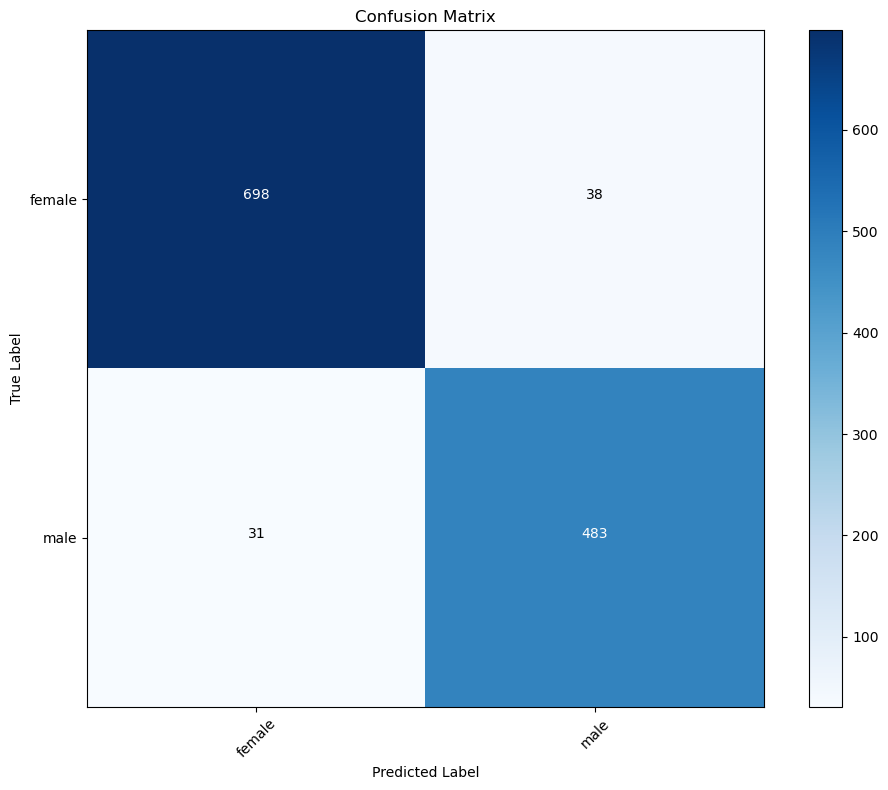

In [12]:
from sklearn.metrics import confusion_matrix

use_gpu = torch.cuda.is_available()
# Compute the predicted labels for the test set
model.eval()  # Set the model to evaluation mode
predicted_labels = []
true_labels = []

for inputs, labels in testLoader:
    if use_gpu:
        inputs = inputs.cuda()
        labels = labels.cuda()
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    predicted_labels.extend(preds.cpu().numpy())
    true_labels.extend(labels.cpu().numpy())

# Create the confusion matrix
confusion_mat = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(confusion_mat, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add values to the cells of the confusion matrix
thresh = confusion_mat.max() / 2
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, format(confusion_mat[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if confusion_mat[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

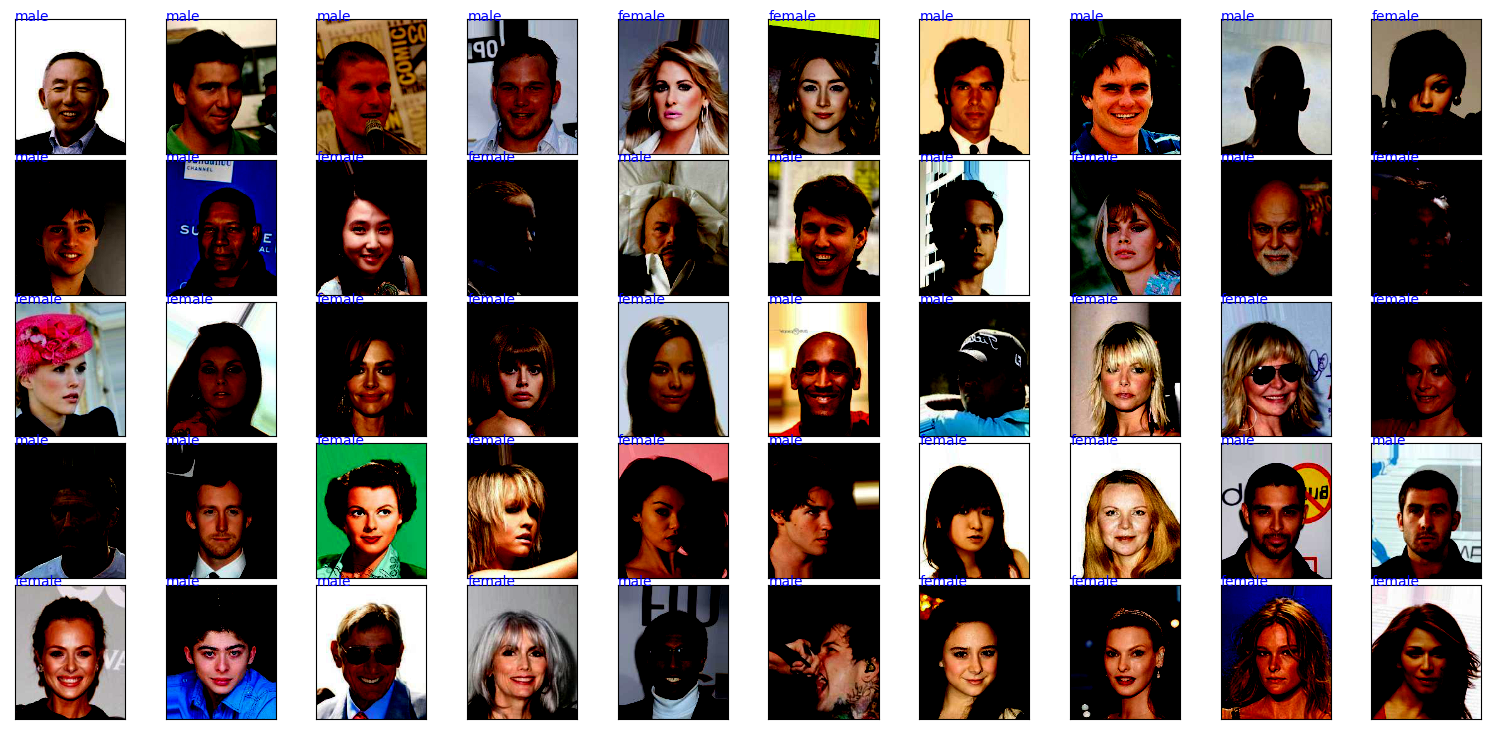

In [13]:
fig = plt.figure(figsize=(15, 7))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

num_images = len(test_set)

test_iter = iter(testLoader)
for i in range(num_images):
    images, labels = next(test_iter)

    with torch.no_grad():
        images = images.to(device)
        pred = model(images)

    images_np = [img.cpu() for img in images]
    
    ax = fig.add_subplot(5, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(images_np[0].permute(1, 2, 0), cmap=plt.cm.gray_r, interpolation='nearest')

    if labels[0] == torch.max(pred[0], 0)[1]:
        ax.text(0, 3, class_names[torch.max(pred[0], 0)[1]], color='blue')
    else:
        ax.text(0, 3, class_names[torch.max(pred[0], 0)[1]], color='red')

    if i == 49:
        break